## Redshift, despite being born as a data warehouse solution, also has support for queries directly on the data lake. Let's test this integration:

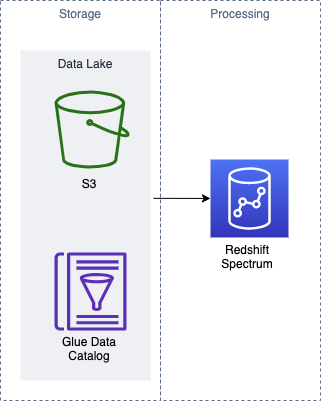

## 1. Install required Python libraries

In [ ]:
!pip install sqlalchemy --upgrade
!pip install simplejson --upgrade
!pip install ipython-sql --upgrade

In [ ]:
# Run this cell to show info about the installed packages
!pip show sqlalchemy
!pip show simplejson
!pip show ipython-sql

## 2. Retrieve your account number

In [ ]:
import simplejson
with open('/opt/ml/metadata/resource-metadata.json') as fh:
    metadata = simplejson.loads(fh.read())
accountid = metadata['ResourceArn'].split(':')[4]
%set_env accountid={accountid}

## 3. Define your username for this session
Please do not use any underscores or start with a number as this will be your Redshift username and used to make an S3 bucket

In [ ]:
##################################### 
# Please add a unique user name value
# Example: username="yourname"
#username="<<_your_username_>>"
username=""
password=""
host_name=""
#####################################
%set_env username={username}
%set_env password={password}

## 4. Define the IAM role used by your Redshift cluster

In [ ]:
redshiftrole="arn:aws:iam::" + accountid + ":role/redshift_spectrum_role"
print(redshiftrole)
%set_env redshiftrole={redshiftrole}

## 5. Create an S3 Bucket

In [ ]:
%%bash
#aws s3 mb s3://lab-${accountid} --region us-east-2
aws s3 ls s3://lab-${accountid}/

## 6. Create a JSON file for your Redshift connection and credentials
You will use the cluster's master user to create your own database and user. Later you will update this file with your username and database name.

---
**For testing only** - Modify the cluster credentials to point to your cluster

In [ ]:
admin_user_name=""
admin_password=""
port_num=5439
db_name="dev"
labs_folder="/home/ec2-user/SageMaker/Analytics_Labs"

%set_env admin_user_name={admin_user_name}
%set_env admin_password={admin_password}
%set_env host_name={host_name}
%set_env port_num={port_num}
%set_env db_name={db_name}
%set_env labs_folder={labs_folder}

In [ ]:
%%bash
echo "{
  \"user_name\": \"$admin_user_name\",
  \"password\": \"$admin_password\",
  \"host_name\": \"$host_name\",
  \"port_num\": \"$port_num\",
  \"db_name\": \"$db_name\"
}" > $labs_folder/admin.creds
ls $labs_folder/*.creds

## 7. Connect to your Redshift cluster
You will use the sqlalchemy and ipython-sql Python libraries to manage the Redshift connection.  

In [ ]:
import sqlalchemy
import psycopg2
import simplejson

%reload_ext sql
%config SqlMagic.displaylimit = 25

with open(labs_folder+"/admin.creds") as fh:
    creds = simplejson.loads(fh.read())
connect_to_db = "postgresql+psycopg2://" + \
                creds["user_name"] +':'+ creds["password"] +'@'+ \
                creds["host_name"] +':'+ creds["port_num"] +'/'+ \
                "dev"; # Default database
%sql $connect_to_db

## 8. Create a new database for yourself
You will use this database for all lab activities  


In [ ]:
create_db='''END;
CREATE DATABASE '''+username+''';'''
%sql $create_db

## 9. Create a new user for yourself
You will use this user to log in to Redshift in all lab activities  


In [ ]:
create_user='''END;
CREATE USER '''+username+''' 
PASSWORD \'''' +password+ '''\' CREATEUSER;'''

%sql $create_user

## 10. Create a JSON file for your Redshift connection and credentials
Update your credentials file with your username and database name.

---
**For testing only** - Modify the cluster credentials to point to your cluster

In [ ]:
%%bash
echo "{
  \"user_name\": \"$username\",
  \"password\": \"$password\",
  \"host_name\": \"$host_name\",
  \"port_num\": \"$port_num\",
  \"db_name\": \"$username\",
  \"accountid\": \"$accountid\"
}" > $labs_folder/client.creds
ls $labs_folder/*.creds

In [ ]:
import sqlalchemy
import psycopg2
import simplejson

%reload_ext sql
%config SqlMagic.displaylimit = 25

with open(labs_folder+"/client.creds") as fh:
    creds = simplejson.loads(fh.read())
connect_to_db = "postgresql+psycopg2://" + \
                creds["user_name"] +':'+ creds["password"] +'@'+ \
                creds["host_name"] +':'+ creds["port_num"] +'/'+ \
                creds["db_name"]; # Default database
%sql $connect_to_db

In [ ]:
external_db_sql = '''END;
create external schema data_lake 
from data catalog database 'movielens' 
iam_role \'''' + redshiftrole + '''\'
region 'us-east-2'; '''

%sql $external_db_sql



In [ ]:
%%sql external_result_set << 
SELECT m.movieid, m.title, avg(cast(r.rating as float)) rating, count(r.rating) votes
FROM data_lake.movies m
JOIN data_lake.ratings r on m.movieid = r.movieid
group by m.movieid, m.title
having count(r.rating) > 1000
order by rating desc
limit 5;


In [ ]:
external_result_set